This notebook aligns calcium imaging data to behavioral events. The user can then define different conditions to subset the data from comparison of activity patterns aligned these events. The notebook then returns a series of plots, heatmaps of both raw and event-based calcium signal for each epoch.

In [379]:
import matplotlib
matplotlib.matplotlib_fname()

'/Users/celia/anaconda/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc'

In [380]:
user_name = 'celia'

In [381]:
import sys
sys.path.append('/Users/{}/GitHub/mouse_bandit/data_preprocessing_code'.format(user_name))
#import support_functions as sf
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as scio
import bandit_preprocessing as bp
import hmm_on_behavior as hob
import calcium_codes as cc
sys.path.append('/Users/{}/GitHub/mouse_bandit/jupyter_notebooks/helper_functions'.format(user_name))
import hf_behavior_imaging as hf
import os
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [408]:
import h5py
record_path = '/Users/{}/GitHub/mouse_bandit/session_record.csv'.format(user_name) # session record of behavioral data
ca_data_path = '/Volumes/Neurobio/MICROSCOPE/Celia/data/imaging/Shay/CaImAn/q45_111716_8020/'.format(user_name)
os.chdir(ca_data_path)

f = h5py.File('caiman-output.h5', 'r+')
neuron = np.array(f['ca'])
f.close()

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Neurobio/MICROSCOPE/Celia/data/imaging/Shay/CaImAn/q45_111716_8020/'

In [409]:
neuron.shape

(64, 45991)

In [410]:
'''Specify mouse and session of interest'''

record = pd.read_csv(record_path,index_col=0) # session record is panda df

session_name  = '11082016_Q45'
mouse_id = 'q45'

record[record['Session ID'] == session_name] # take only rows from record that match session name


'''Load in trial data from specific session'''

columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked',
           'Right Reward Prob','Left Reward Prob','Reward Given',
          'center_frame','decision_frame']

root_dir = '/Users/{}/GitHub/mouse_bandit/data/trial_data'.format(user_name)

full_name = session_name + '_trials.csv'

path_name = os.path.join(root_dir,full_name)

trial_df = pd.read_csv(path_name,names=columns)

In [385]:
record[record['Session ID'] == session_name]

,Owner,Session ID,Mouse ID,Date,Phase,Markov,Left Reward Prob,Right Reward Prob,Block Range Min,Block Range Max,No. Trials,No. Blocks,No. Rewards,p(high Port),Decision Window Duration,Min Inter-trial-interval,Left Solenoid Duration,Right Solenoid Duration


In [386]:
trial_df.head()

,Elapsed Time (s),Since last trial (s),Trial Duration (s),Port Poked,Right Reward Prob,Left Reward Prob,Reward Given,center_frame,decision_frame
0,24.735,1.323,1.153,2,0.8,0.2,0,233,268
1,67.047,17.569,1.274,2,0.8,0.2,0,1498,1536
2,139.760,4.420,0.560,1,0.8,0.2,1,3700,3717
3,142.400,2.154,0.481,1,0.8,0.2,1,3782,3796
4,146.730,3.890,0.446,1,0.8,0.2,1,3913,3927


In [387]:
reward_prob = 0.7
blocks_right = np.sum(trial_df['Right Reward Prob']==reward_prob)/trial_df.shape[0] # check balance of blocks on each side
print('right block proportion = %s' % blocks_right) # for 50 reward block structure I guess this isn't really necessary

blocks = list(np.diff(np.concatenate((range(1),np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0]))))
blocks.append(int(record[record['Session ID']==session_name]['No. Trials'].values)
             -np.where(np.diff(trial_df['Right Reward Prob']) != 0)[0][-1]) # length of the last block at end
blocks

right block proportion = 0.0


TypeError: only length-1 arrays can be converted to Python scalars

### Add column for estimated by HMM using entire session as memory

In [ ]:
columns.append('Block ID')

block_id = np.asarray([x+1 for x in range(int(record[record['Session ID']==session_name]['No. Blocks'].values[0])+1)
            for y in range(blocks[x])])
trial_df['Block ID'] = block_id

In [ ]:
trial_df.head(5)

# convert to feature matrix
### Add column for beliefs using past (n) trials as memory (n <= 10)

In [388]:
feature_matrix = bp.create_feature_matrix(trial_df,10,mouse_id,session_name,feature_names='Default',imaging=True)

In [389]:
feature_matrix[['Port Streak','Decision','Switch', 'Reward']].head(5) # look at only a few columns

,Port Streak,Decision,Switch,Reward
0,8.0,0.0,0.0,0.0
1,9.0,0.0,0.0,1.0
2,10.0,0.0,0.0,1.0
3,11.0,0.0,0.0,1.0
4,12.0,1.0,1.0,0.0


In [390]:
feature_matrix.head(10)

,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,...,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,center_frame,decision_frame
0,q45,11082016_Q45,11.0,11.0,8.0,8.0,8.0,1.0,0.0,1.323,...,3.703,0.563,3.336,0.551,0.0,0.0,1.0,0.0,4666.0,4682.0
1,q45,11082016_Q45,12.0,12.0,8.0,9.0,-1.0,1.0,0.0,17.569,...,3.336,0.551,2.530,0.520,0.0,0.0,1.0,1.0,4758.0,4774.0
2,q45,11082016_Q45,13.0,13.0,9.0,10.0,1.0,0.0,1.0,4.420,...,2.530,0.520,2.765,0.446,0.0,0.0,1.0,1.0,4857.0,4870.0
3,q45,11082016_Q45,14.0,14.0,10.0,11.0,2.0,0.0,1.0,2.154,...,2.765,0.446,2.560,0.471,0.0,0.0,1.0,1.0,4947.0,4961.0
4,q45,11082016_Q45,15.0,15.0,11.0,12.0,3.0,0.0,1.0,3.890,...,2.560,0.471,1.472,0.643,1.0,1.0,0.0,0.0,5480.0,5499.0
5,q45,11082016_Q45,16.0,16.0,11.0,1.0,-1.0,0.0,1.0,1.334,...,1.472,0.643,1.635,0.664,1.0,0.0,0.0,1.0,5557.0,5577.0
6,q45,11082016_Q45,17.0,17.0,12.0,2.0,1.0,0.0,1.0,2.421,...,1.635,0.664,2.315,0.504,1.0,0.0,0.0,0.0,6137.0,6152.0
7,q45,11082016_Q45,18.0,18.0,12.0,3.0,-1.0,0.0,1.0,3.211,...,2.315,0.504,1.207,0.757,1.0,0.0,0.0,0.0,6245.0,6268.0
8,q45,11082016_Q45,19.0,19.0,12.0,4.0,-2.0,0.0,1.0,3.199,...,1.207,0.757,1.170,0.606,0.0,1.0,1.0,1.0,6302.0,6321.0
9,q45,11082016_Q45,20.0,20.0,13.0,1.0,1.0,0.0,1.0,3.703,...,1.170,0.606,2.349,0.577,0.0,0.0,1.0,1.0,7080.0,7098.0


In [391]:
feature_matrix.columns

Index(['Mouse ID', 'Session ID', 'Trial', 'Block Trial', 'Block Reward',
       'Port Streak', 'Reward Streak', '10_Port', '10_Reward', '10_ITI',
       '10_trialDuration', '9_Port', '9_Reward', '9_ITI', '9_trialDuration',
       '8_Port', '8_Reward', '8_ITI', '8_trialDuration', '7_Port', '7_Reward',
       '7_ITI', '7_trialDuration', '6_Port', '6_Reward', '6_ITI',
       '6_trialDuration', '5_Port', '5_Reward', '5_ITI', '5_trialDuration',
       '4_Port', '4_Reward', '4_ITI', '4_trialDuration', '3_Port', '3_Reward',
       '3_ITI', '3_trialDuration', '2_Port', '2_Reward', '2_ITI',
       '2_trialDuration', '1_Port', '1_Reward', '1_ITI', '1_trialDuration',
       '0_ITI', '0_trialDuration', 'Decision', 'Switch', 'Higher p port',
       'Reward', 'center_frame', 'decision_frame'],
      dtype='object')

### Set the parameters to input into extract_frames function
    Decision: 0=Right, 1=Left
    Reward: 0=unrewarded, 1=rewarded
    Switch: 0=last trial at same port, 1=last trial at different port-->switched
    Belief: 0-1 value where 0 represents right port and 1 represents left port

In [392]:
cond1_name = '1_Reward'; cond1_id=[0,1]
cond1_ops = '='

cond2_name = 'Reward'; cond2_id=[0,1]

cond3_name = 'Decision'; cond3_id=[0,1]

conditions = [cond1_name, cond2_name, cond3_name]
n_variables = 2 # value between 1 and 3 to run the corresponding number of conditions through the rest of the notebook
extension = 30 # number of frames included before center poke and after decision poke to set size of window
combo_id = list(itertools.product([0, 1], repeat=n_variables)) # list of all combinations of binary conditions
n_combos = len(combo_id) # total number of combinations of conditions

if 'cond1_ops' in vars():
    cond1_ops_b='=' # make sure the alternative operation fits with its partner 
    if cond1_ops != '=':
        if cond1_ops == '>':
            cond1_ops_b = '<='
            print(cond1_ops_b)
        elif cond1_ops == '>=':
            cond1_ops_b = '<'
            print(cond1_ops_b)

### Extract the frames for the specified conditions and create arrays containing frames for beginning and end of window of interest

    Set the value of 'extension' to the # of frames added before the center poke and after the decision poke
    fr_1x2x3x = center poke, decision poke frame #s for all trials with the corresponding conditions.

    At the moment this is not set up in the most efficient way...the extract_frames function operates by calling all 3 variables (i.e. Switch, Reward) across both conditions (a=0, b=1) to generate the maximum number of combinations (8 for 3 variables). If the number of variables is less than 3, it will later use the 'groupings_x' variables to concatenate these arrays into the appropriate final arrays (for example, to go from 3 variables to 2, all beginning with 1a2a get combined)

In [393]:
poke_frames = {} # initialize an empty dictionary to store center and decision poke frames for each combination of conditions
for i in range(0,n_combos):
    if n_variables==3: # based on number of variables specified
        iCombo_key= "f%s%s%s" % (combo_id[i][0], combo_id[i][1], combo_id[i][2]) # set key name based on comboID
        iCombo_value = hf.extract_frames(feature_matrix, cond1_name, combo_id[i][0], cond2_name, 
                                         combo_id[i][1], cond3_name, combo_id[i][2], cond1_ops=cond1_ops)
        temp_dict = {iCombo_key:iCombo_value} # create new key-value pair with comboID and corresponding frames
        poke_frames.update(temp_dict) # add new values to dictionary of center and decision poke frames
    if n_variables==2:
        iCombo_key= "f%s%s" % (combo_id[i][0], combo_id[i][1])
        iCombo_value = hf.extract_frames(feature_matrix, cond1_name, combo_id[i][0], cond2_name, 
                                         combo_id[i][1], cond1_ops=cond1_ops)
        temp_dict = {iCombo_key:iCombo_value}
        poke_frames.update(temp_dict)
    if n_variables==1:
        iCombo_key= "f%s" %(combo_id[i][0])
        iCombo_value = hf.extract_frames(feature_matrix, cond1_name, combo_id[i][0], cond1_ops=cond1_ops)
        temp_dict = {iCombo_key:iCombo_value}
        poke_frames.update(temp_dict)
    
poke_frames_keys = list(poke_frames.keys())

### Create a dictionary referencing every array of start/stop frames
    Start-stop_frames = frame starting however long the extension value was before the center poke frame, and frame that long after the decision poke
    Dictionary is designed to construct each array based on the number of variables (conditions) specified in the beginning...this is where the groupings variables are used to condense arrays for fewer conditions.

In [394]:
for i in poke_frames: # create full window based on number of frames in 'extension' variable
    poke_frames[i][:,0] = poke_frames[i][:,0] - extension
    poke_frames[i][:,1] = poke_frames[i][:,1] + extension

### Set up some other parameters to be used in the rest of the script
    detectEvents() returns binary matrix of 0s and 1s representing frames where events occurred. Replace raw trace file with this processed file and apply a Gaussian filter over events.
    
    --nNeurons = number of neurons output by CNMF-e
        Redefined as number of neurons after some initial processing:

    Working on a function to combine the above with previous execution of this script on the raw trace file using a flag for 'events'. Once that's complete, will need to add back in NaN cleansing (this is already incorporated into the detectEvents() function). The following arrays will then be used.
    
    --nan_neurons = any neurons containing NaNs in their calcium traces
    --good_neurons = neurons not containing NaNs -- used to redefine nNeurons

In [395]:
events = cc.detectEvents(neuron)
nNeurons = neuron.shape[0]
nFrames = neuron.shape[1]

In [396]:
# baseline subtraction
for iNeuron in range(nNeurons):
    neuron[iNeuron,:] = neuron[iNeuron,:] - np.median(neuron[iNeuron,:])

In [397]:
events[np.where(events > 0)] = 1 # set value of events to 1 so it's binary (should probably change in detectEvents)

### Some normalization across entire session

### Calculate the number of frames required to span the longest trial in all conditions, and use this for all trials
    --nTrials = list of number of trials in each condition (length = n_combos)

    --max_window = find window length (number of frames) required to capture center poke to decision poke for all trials (with extensions) and then just take maximum length trial across all conditions)

In [398]:
nTrials = [poke_frames[poke_frames_keys[i]].shape[0] for i in range(n_combos)]
max_window = np.zeros(n_combos) 
window_length= np.zeros((np.max(nTrials), n_combos))
    
for i in range(n_combos):
    for iTrial in range(nTrials[i]):
        window_length[iTrial, i] = int(((poke_frames[poke_frames_keys[i]][iTrial][1]-
                                 poke_frames[poke_frames_keys[i]][iTrial][0])))
    max_window[i] = np.max(window_length)
    
max_window = int(max_window.max())

### Aligned to center poke
    Pull out segments of calcium traces in designated window of frames. Calculate mean fluorescence for each neuron across all trials. 
    -- aligned_start = (number of trials x number frames x number of neurons x number of combinations)
    -- mean_center_poke = mean fluorescence (or mean number of events) for each neuron across all trials aligned to center poke
    
    If using raw traces, will add back in normalization here.


In [399]:
aligned_start = np.zeros((np.max(nTrials), max_window, nNeurons, n_combos))
aligned_start_raw = np.zeros((np.max(nTrials), max_window, nNeurons, n_combos))

for i in range(n_combos):

    # create array containing segment of raw trace for each neuron for each trial 
    # aligned to center poke
    for iNeuron in range(nNeurons): # for each neuron
        for iTrial in range(0,nTrials[i]): # and for each trial
            try:
                aligned_start[iTrial,:, iNeuron, i] = events[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][0]):
                    (int(poke_frames[poke_frames_keys[i]][iTrial][0])+max_window)]
                
                aligned_start_raw[iTrial,:, iNeuron, i] = neuron[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][0]):
                    (int(poke_frames[poke_frames_keys[i]][iTrial][0])+max_window)]
                
            except ValueError: # this happens when the last trial was shorter than the max_window
                try:
                    len_to_end = int(nFrames - poke_frames[poke_frames_keys[i]][iTrial][0])
                    aligned_start[iTrial,0:len_to_end, iNeuron, i] = events[iNeuron,
                        int(poke_frames[poke_frames_keys[i]][iTrial][0]):
                        (int(poke_frames[poke_frames_keys[i]][iTrial][0])+len_to_end)]
                    
                    aligned_start_raw[iTrial,0:len_to_end, iNeuron, i] = neuron[iNeuron,
                        int(poke_frames[poke_frames_keys[i]][iTrial][0]):
                        (int(poke_frames[poke_frames_keys[i]][iTrial][0])+len_to_end)]
                    
                except ValueError: # this happens if there's an entire trial after imaging stopped...why would this happen?
                    pass
                
   
    # baseline subtraction
    for iTrial in range(nTrials[i]):
        for iNeuron in range(nNeurons):
            aligned_start_raw[iTrial,:,iNeuron,i] = aligned_start_raw[iTrial,:,iNeuron,i] - np.median(aligned_start_raw[iTrial,:,iNeuron,i])


### look at baseline-subtraced raw traces

In [400]:
aligned_start_raw = aligned_start_raw-aligned_start_raw.min() # get rid of negative values

### dF/F traces (centered at 0 baseline) normalized to each neuron's activity within the aligned window

In [401]:
norm_raw = np.zeros_like(aligned_start)

# take max and min values for each neuron
raw_min = [np.min(aligned_start_raw[:,:,x,:]) for x in range(nNeurons)]
raw_max = [np.max(aligned_start_raw[:,:,x,:]) for x in range(nNeurons)]

for iNeuron in range(nNeurons):
    norm_raw[:,:,iNeuron,:] = (aligned_start_raw[:,:,iNeuron,:] - raw_min[iNeuron])/(raw_max[iNeuron] - raw_min[iNeuron])


### dF/F traces (centered at 0 baseline) normalized to ALL neurons' activity within the aligned window

In [402]:
# Normalize each trace across entire imaging session based on single neuron’s activity

# take max and min values for each neuron
raw_min = neuron.min(axis=1)
raw_max = neuron.max(axis=1)

norm_raw = np.zeros_like(aligned_start)
for iNeuron in range(nNeurons):
    norm_raw[:,:,iNeuron,:] = (aligned_start_raw[:,:,iNeuron,:] - raw_min[iNeuron])/(raw_max[iNeuron] - raw_min[iNeuron])


### decision poke

In [403]:
aligned_decision = np.zeros((np.max(nTrials), max_window, nNeurons, n_combos))
aligned_decision_raw = np.zeros((np.max(nTrials), max_window, nNeurons, n_combos))

for i in range(n_combos):

    # create array containing segment of raw trace for each neuron for each trial 
    # aligned to center poke
    for iNeuron in range(nNeurons): # for each neuron
        for iTrial in range(0,nTrials[i]): # and for each trial
            try:
                aligned_decision[iTrial,:, iNeuron, i] = events[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][1])-max_window:
                    (int(poke_frames[poke_frames_keys[i]][iTrial][1]))]
                
                aligned_decision_raw[iTrial,:, iNeuron, i] = neuron[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][1])-max_window:
                    (int(poke_frames[poke_frames_keys[i]][iTrial][1]))]
                
            except ValueError: # for first trial where cannot fill max_window length
                
                len_to_start = int(nFrames - poke_frames[poke_frames_keys[i]][iTrial][1])
                aligned_decision[iTrial,abs(len_to_start):max_window, iNeuron, i] = events[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][1])-max_window:
                    (int(poke_frames[poke_frames_keys[i]][iTrial][1]))]
                
                aligned_decision_raw[iTrial,abs(len_to_start):max_window, iNeuron, i] = neuron[iNeuron,
                    int(poke_frames[poke_frames_keys[i]][iTrial][1])-max_window:
                    (int(poke_frames[poke_frames_keys[i]][iTrial][1]))]                
            
 # baseline subtraction
    for iTrial in range(nTrials[i]):
        for iNeuron in range(nNeurons):
            aligned_decision[iTrial,:,iNeuron,i] = aligned_decision[iTrial,:,iNeuron,i] - np.median(aligned_decision[iTrial,:,iNeuron,i])
            aligned_decision_raw[iTrial,:,iNeuron,i] = aligned_decision_raw[iTrial,:,iNeuron,i] - np.median(aligned_decision_raw[iTrial,:,iNeuron,i])


### simulate photometry data

In [404]:
photometry_aligned_center = np.sum(aligned_start_raw, axis=2)
photometry_mean_center = np.mean(photometry_aligned_center, axis=0)
photometry_std_center = np.std(photometry_aligned_center, axis=0)

['1_Reward', 'Reward']


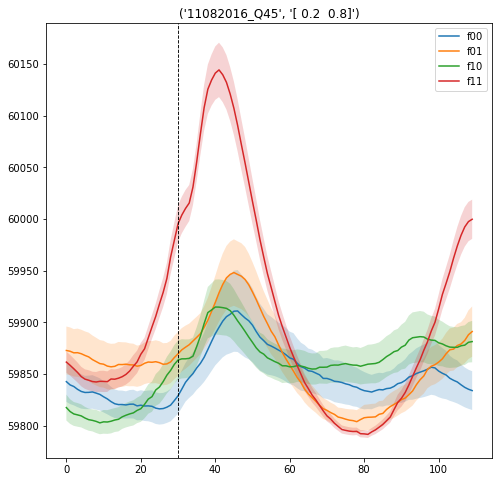

In [405]:
ydim=n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):
    plt.plot(photometry_mean_center[:,i])
    plt.fill_between(range(0,max_window),y1=photometry_mean_center[:,i] - photometry_std_center[:,i] / np.sqrt(nTrials[i]), 
                                    y2 = photometry_mean_center[:,i] + photometry_std_center[:,i] / np.sqrt(nTrials[i]) ,alpha=0.2)
    plt.legend(poke_frames_keys)
plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
plt.title((session_name, str(np.unique(trial_df['Left Reward Prob']))))
print(conditions[0:n_variables])

In [406]:
photometry_aligned_decision = np.sum(aligned_decision_raw, axis=2)
photometry_mean_decision = np.mean(photometry_aligned_decision, axis=0)
photometry_std_decision = np.std(photometry_aligned_decision, axis=0)

['1_Reward', 'Reward']


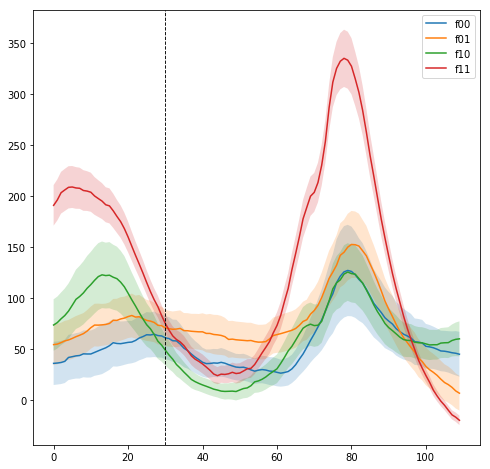

In [407]:
ydim=n_combos/2
plt.figure(figsize=(8,ydim*4))
for i in range(n_combos):
    plt.plot(photometry_mean_decision[:,i])
    plt.fill_between(range(0,max_window),y1=photometry_mean_decision[:,i] - photometry_std_decision[:,i] / np.sqrt(nTrials[i]), 
                                    y2 = photometry_mean_decision[:,i] + photometry_std_decision[:,i] / np.sqrt(nTrials[i]) ,alpha=0.2)
    plt.legend(poke_frames_keys)
plt.axvline(x=extension, color='k', linestyle = '--', linewidth=.9)
print(conditions[0:n_variables])